In [3]:
from database_utils import *
from data_creation import *
import psycopg2
from database_functions import *

OpenCV is not installed correctly. Please install it to use this module.


In [30]:
def create_continuous_aggregate_view_no_refresh(table_name):
    view_name = f"{table_name}_daily_row_count"
    with psycopg2.connect(CONNECTION) as conn:
        cur = conn.cursor()
        cur.execute(f"""
            CREATE MATERIALIZED VIEW {view_name}
            WITH (timescaledb.continuous) AS
            SELECT time_bucket('1 day', datetime) AS day,
                   COUNT(*) AS row_count
            FROM {table_name}
            GROUP BY day
            WITH NO DATA;
        """)
        conn.commit()


def set_daily_refresh_policy(view_name):
    with psycopg2.connect(CONNECTION) as conn:
        cur = conn.cursor()
        cur.execute(f"""
            SELECT add_continuous_aggregate_policy('{view_name}',
                start_offset => INTERVAL '2 day',
                end_offset => INTERVAL '0 min',
                schedule_interval => INTERVAL '1 day');
        """)
        conn.commit()
    
def check_daily_row_count(table_name):
    view_name = f"{table_name}_daily_row_count"
    with psycopg2.connect(CONNECTION) as conn:
        cur = conn.cursor()
        cur.execute(f"SELECT * FROM {view_name};")
        results = cur.fetchall()
    return results
         
     

In [39]:
data = check_daily_row_count('mexico_lance_a_63')

<Axes: xlabel='day'>

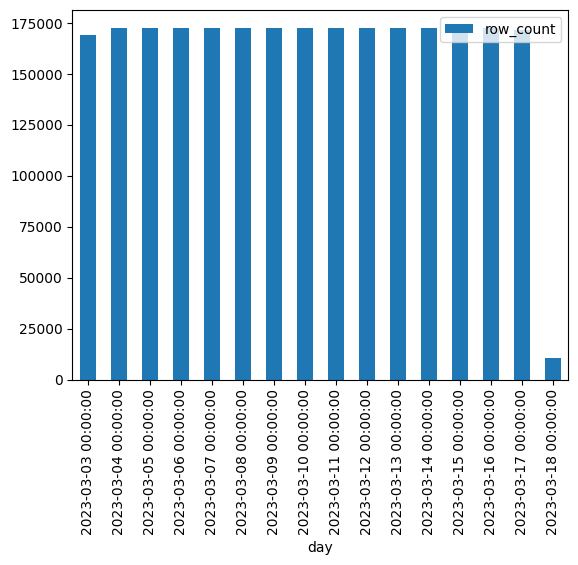

In [36]:
pd.DataFrame(data, columns=['day', 'row_count']).plot(kind='bar', x='day', y='row_count')

In [40]:
get_min_date_of_table('mro_61')

datetime.datetime(2021, 3, 1, 5, 18, 0, 41000)

In [ ]:
count_rows_of_data_per_day_per_table_sql

In [2]:
min_max_date = {}
for table in get_table_names_sql():
    min_max_date[table] = get_min_max_datetime_from_table_sql(table)

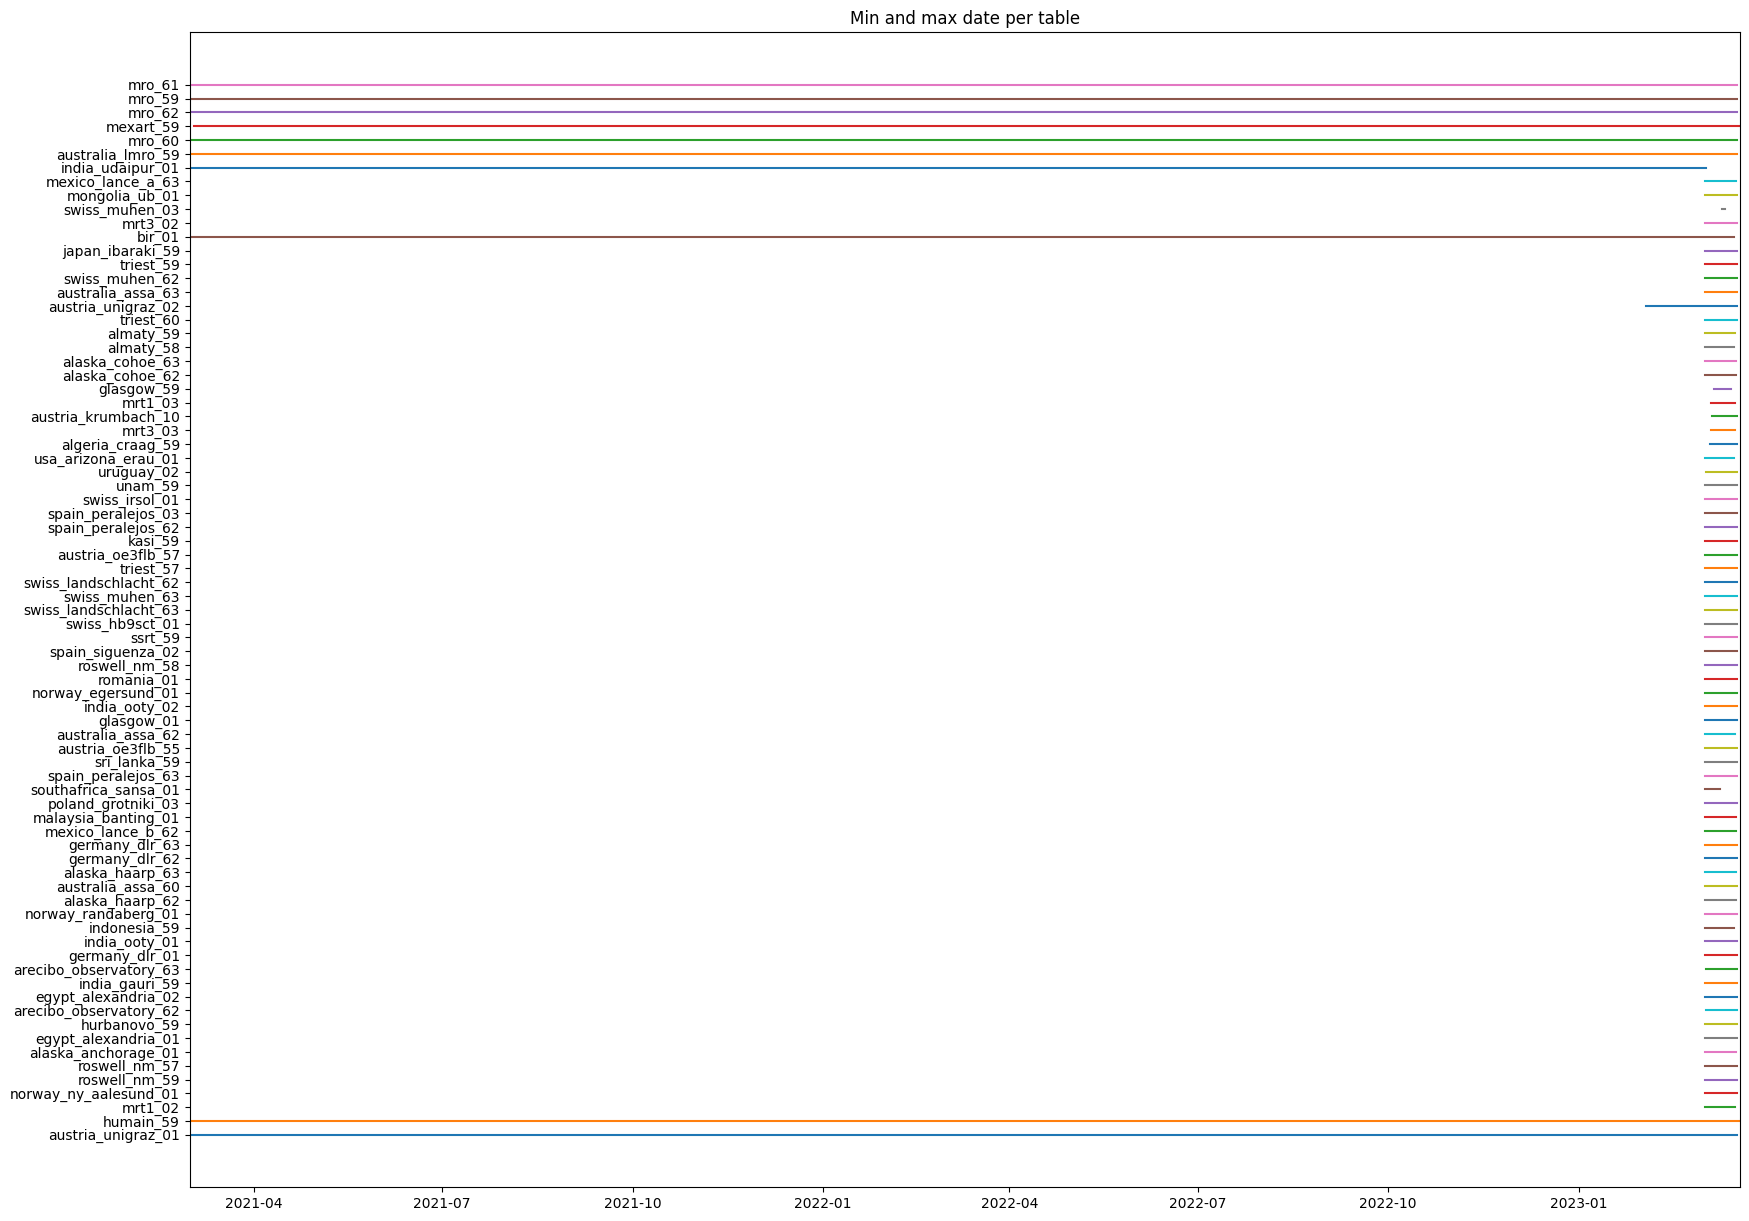

In [3]:
# Plot per table the min_max date, which each table being a horizontal line.
import matplotlib.pyplot as plt

x_values = []
y_values = []

for key, value in min_max_date.items():
    x_values.append(value[0])
    y_values.append(value[1])

min_datetime = min(x_values + y_values)
max_datetime = max(x_values + y_values)

fig, ax = plt.subplots(figsize=(20, 15))
for key, value in min_max_date.items():
    ax.plot(value, [key]*2)

ax.set_xlim([min_datetime, max_datetime])
ax.xaxis_date()

plt.title("Min and max date per table")
plt.show()
